# Serialization Demo

This notebook demonstrates how to save and load fitted distributions using spark-bestfit's serialization feature.

**Use Cases:**
- Persist fitted models for later inference
- Share models between team members or environments
- Create model registries for production deployments
- Debug and inspect fitted distributions

## Setup

In [1]:
import numpy as np
import json
from pathlib import Path
import tempfile
import shutil

from pyspark.sql import SparkSession

# Create Spark session
spark = (
    SparkSession.builder
    .appName("Serialization-Demo")
    .config("spark.sql.shuffle.partitions", "10")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/02 22:54:08 WARN Utils: Your hostname, 2025m5.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
26/01/02 22:54:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


26/01/02 22:54:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.0


In [2]:
from spark_bestfit import DistributionFitter, DistributionFitResult, SerializationError

In [3]:
# Create a temporary directory for our models
MODEL_DIR = Path(tempfile.mkdtemp())
print(f"Model directory: {MODEL_DIR}")

Model directory: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmp16ztysct


## Generate Sample Data

We'll create sample data from known distributions.

In [4]:
np.random.seed(42)

# Generate gamma-distributed data (e.g., response times)
gamma_data = np.random.gamma(shape=2.0, scale=5.0, size=50_000)
df_gamma = spark.createDataFrame([(float(x),) for x in gamma_data], ["response_time"])

print(f"Generated {df_gamma.count():,} samples")
print(f"Mean: {gamma_data.mean():.2f}, Std: {gamma_data.std():.2f}")
print(f"Range: [{gamma_data.min():.2f}, {gamma_data.max():.2f}]")

Generated 50,000 samples
Mean: 10.00, Std: 7.08
Range: [0.03, 68.47]


---

# Part 1: Basic Save and Load

Fit a distribution, save it, and reload it.

In [5]:
# Fit distributions
fitter = DistributionFitter(spark)
results = fitter.fit(
    df_gamma, 
    column="response_time",
    support_at_zero=True,  # Response times are non-negative
    max_distributions=20,
)

# Get the best fit
best = results.best(n=1)[0]
print(f"Best distribution: {best.distribution}")
print(f"Parameters: {best.parameters}")
print(f"K-S statistic: {best.ks_statistic:.6f}")
print(f"p-value: {best.pvalue:.4f}")

Best distribution: exponweib
Parameters: [1.561938762664795, 1.1588444709777832, 0.06502599269151688, 8.148895263671875]
K-S statistic: 0.003664
p-value: 0.9992


### Save to JSON (Default)

In [6]:
# Save to JSON (human-readable, recommended)
json_path = MODEL_DIR / "response_time_model.json"
best.save(json_path)

print(f"Saved to: {json_path}")
print(f"File size: {json_path.stat().st_size:,} bytes")
print()

# View the JSON content
with open(json_path) as f:
    print(f.read())

Saved to: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmp16ztysct/response_time_model.json
File size: 764 bytes

{
  "schema_version": "1.1",
  "spark_bestfit_version": "1.7.2",
  "created_at": "2026-01-02T15:54:15.989253+00:00",
  "distribution": "exponweib",
  "parameters": [
    1.561938762664795,
    1.1588444709777832,
    0.06502599269151688,
    8.148895263671875
  ],
  "column_name": "response_time",
  "metrics": {
    "sse": 3.507123255985789e-05,
    "aic": 63807.3984375,
    "bic": 63836.2421875,
    "ks_statistic": 0.00366380182094872,
    "pvalue": 0.9992413520812988,
    "ad_statistic": 0.11482905596494675,
    "ad_pvalue": null
  },
  "data_summary": {
    "std": 7.065908432006836,
    "min": 0.09240243583917618,
    "sample_size": 10007.0,
    "max": 67.78553009033203,
    "mean": 9.987296104431152
  },
  "lower_bound": null,
  "upper_bound": null
}


### Load and Use

In [7]:
# Load the saved model
loaded = DistributionFitResult.load(json_path)

print(f"Loaded distribution: {loaded.distribution}")
print(f"Parameters: {loaded.parameters}")

# Verify it's identical to the original
assert loaded.distribution == best.distribution
assert loaded.parameters == best.parameters
assert loaded.ks_statistic == best.ks_statistic
print("\nVerified: loaded model matches original!")

Loaded distribution: exponweib
Parameters: [1.561938762664795, 1.1588444709777832, 0.06502599269151688, 8.148895263671875]

Verified: loaded model matches original!


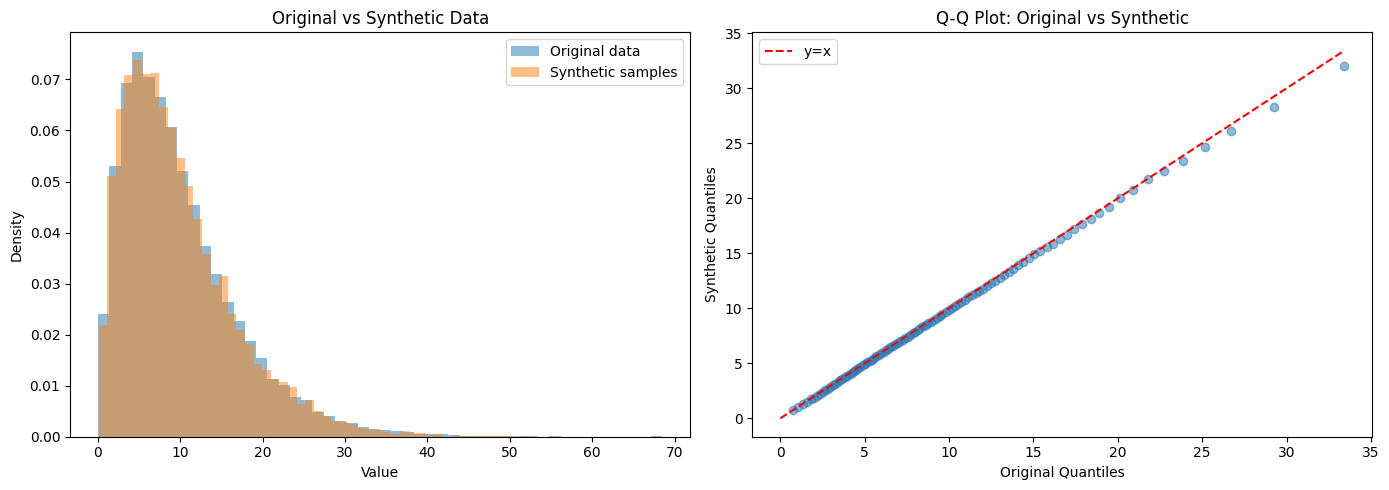

Original mean: 10.00, Synthetic mean: 9.83
Original std:  7.08, Synthetic std:  6.92


In [8]:
# Use the loaded model for inference
import matplotlib.pyplot as plt
%matplotlib inline

# Generate samples from the loaded model
synthetic_samples = loaded.sample(size=10_000, random_state=42)

# Compare distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histograms
ax1.hist(gamma_data, bins=50, density=True, alpha=0.5, label="Original data")
ax1.hist(synthetic_samples, bins=50, density=True, alpha=0.5, label="Synthetic samples")
ax1.set_xlabel("Value")
ax1.set_ylabel("Density")
ax1.set_title("Original vs Synthetic Data")
ax1.legend()

# Q-Q plot
original_quantiles = np.percentile(gamma_data, np.linspace(1, 99, 100))
synthetic_quantiles = np.percentile(synthetic_samples, np.linspace(1, 99, 100))
ax2.scatter(original_quantiles, synthetic_quantiles, alpha=0.5)
ax2.plot([0, max(original_quantiles)], [0, max(original_quantiles)], 'r--', label="y=x")
ax2.set_xlabel("Original Quantiles")
ax2.set_ylabel("Synthetic Quantiles")
ax2.set_title("Q-Q Plot: Original vs Synthetic")
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Original mean: {gamma_data.mean():.2f}, Synthetic mean: {synthetic_samples.mean():.2f}")
print(f"Original std:  {gamma_data.std():.2f}, Synthetic std:  {synthetic_samples.std():.2f}")

<cell_type>markdown</cell_type>---

# Part 2: Data Statistics for Debugging

The data statistics fields provide lightweight provenance tracking - basic statistics about the data used for fitting.

In [ ]:
# Access data statistics from the original result (v2.0+ flat field API)
print("Data Statistics (captured during fitting):")
print(f"  Sample size: {best.data_count:,.0f}")
print(f"  Min:         {best.data_min:.4f}")
print(f"  Max:         {best.data_max:.4f}")
print(f"  Mean:        {best.data_mean:.4f}")
print(f"  Std:         {best.data_stddev:.4f}")

print("\nActual data statistics:")
print(f"  Sample size: {len(gamma_data):,}")
print(f"  Min:         {gamma_data.min():.4f}")
print(f"  Max:         {gamma_data.max():.4f}")
print(f"  Mean:        {gamma_data.mean():.4f}")
print(f"  Std:         {gamma_data.std():.4f}")

In [ ]:
# Data statistics are preserved through serialization
loaded = DistributionFitResult.load(json_path)

print("Data Statistics (from loaded model):")
if loaded.data_count is not None:
    print(f"  sample_size: {loaded.data_count:,.0f}")
    print(f"  min:         {loaded.data_min:.4f}")
    print(f"  max:         {loaded.data_max:.4f}")
    print(f"  mean:        {loaded.data_mean:.4f}")
    print(f"  std:         {loaded.data_stddev:.4f}")
else:
    print("  No data statistics available")

### Use Case: Drift Detection with K-S Test

Since we have the full fitted distribution, we can use proper statistical tests to detect data drift - not just summary statistics.

In [11]:
from scipy import stats

def check_data_compatibility(model: DistributionFitResult, new_data: np.ndarray) -> dict:
    """Check if new data is compatible with the fitted model using K-S test.
    
    This uses the actual fitted distribution, not just summary statistics.
    """
    # Get the scipy distribution object
    dist = getattr(stats, model.distribution)
    fitted_dist = dist(*model.parameters)
    
    # K-S test: compare new data against the fitted distribution
    ks_result = stats.kstest(new_data, fitted_dist.cdf)
    
    # Coverage check: what % of data falls in expected 1-99% range
    p01, p99 = fitted_dist.ppf(0.01), fitted_dist.ppf(0.99)
    coverage = np.mean((new_data >= p01) & (new_data <= p99)) * 100
    
    result = {
        "ks_statistic": ks_result.statistic,
        "ks_pvalue": ks_result.pvalue,
        "coverage_pct": coverage,
        "expected_range": (p01, p99),
    }
    
    # Interpret results
    warnings = []
    if ks_result.pvalue < 0.05:
        warnings.append(f"K-S test rejected (p={ks_result.pvalue:.4f}): data differs from fitted distribution")
    if coverage < 90:
        warnings.append(f"Only {coverage:.1f}% of data in expected 1-99% range")
    
    if warnings:
        result["status"] = "warning"
        result["message"] = "Potential data drift detected"
        result["warnings"] = warnings
    else:
        result["status"] = "ok"
        result["message"] = f"Data compatible (KS p={ks_result.pvalue:.3f}, {coverage:.1f}% coverage)"
    
    return result


# Test with similar data (should be OK)
np.random.seed(123)  # Different seed than training
similar_data = np.random.gamma(shape=2.0, scale=5.0, size=1000)
result = check_data_compatibility(loaded, similar_data)
print("Similar data (same distribution):")
print(f"  Status: {result['status']}")
print(f"  Message: {result['message']}")

# Test with drifted data (should warn)
print()
drifted_data = np.random.gamma(shape=5.0, scale=10.0, size=1000)
result = check_data_compatibility(loaded, drifted_data)
print("Drifted data (different distribution):")
print(f"  Status: {result['status']}")
print(f"  Message: {result['message']}")
if 'warnings' in result:
    for warning in result['warnings']:
        print(f"  ⚠ {warning}")

Similar data (same distribution):
  Status: ok
  Message: Data compatible (KS p=0.211, 98.4% coverage)

Drifted data (different distribution):
  Status: warning
  Message: Potential data drift detected
  ⚠ K-S test rejected (p=0.0000): data differs from fitted distribution
  ⚠ Only 23.8% of data in expected 1-99% range


---

# Part 3: Multi-Distribution Persistence

Save multiple distributions from the same fitting session.

In [12]:
# Get top 5 distributions
top_5 = results.best(n=5)

print("Top 5 distributions:")
for i, fit in enumerate(top_5, 1):
    print(f"  {i}. {fit.distribution:15} KS={fit.ks_statistic:.6f} p={fit.pvalue:.4f}")

Top 5 distributions:
  1. exponweib       KS=0.003664 p=0.9992
  2. gamma           KS=0.006256 p=0.8259
  3. erlang          KS=0.006261 p=0.8252
  4. f               KS=0.006277 p=0.8228
  5. betaprime       KS=0.006379 p=0.8077


In [13]:
# Save each to a separate file with a manifest
models_dir = MODEL_DIR / "multi_models"
models_dir.mkdir(exist_ok=True)

manifest = {
    "column": "response_time",
    "best_by": "ks_statistic",
    "models": []
}

for rank, fit in enumerate(top_5, 1):
    filename = f"rank_{rank}_{fit.distribution}.json"
    filepath = models_dir / filename
    fit.save(filepath)
    
    manifest["models"].append({
        "rank": rank,
        "distribution": fit.distribution,
        "file": filename,
        "ks_statistic": fit.ks_statistic,
        "pvalue": fit.pvalue,
    })
    print(f"Saved: {filename}")

# Save manifest
manifest_path = models_dir / "manifest.json"
with open(manifest_path, 'w') as f:
    json.dump(manifest, f, indent=2)

print(f"\nManifest saved to: {manifest_path}")

Saved: rank_1_exponweib.json
Saved: rank_2_gamma.json
Saved: rank_3_erlang.json
Saved: rank_4_f.json
Saved: rank_5_betaprime.json

Manifest saved to: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmp16ztysct/multi_models/manifest.json


In [14]:
# View the manifest
with open(manifest_path) as f:
    print(f.read())

{
  "column": "response_time",
  "best_by": "ks_statistic",
  "models": [
    {
      "rank": 1,
      "distribution": "exponweib",
      "file": "rank_1_exponweib.json",
      "ks_statistic": 0.00366380182094872,
      "pvalue": 0.9992413520812988
    },
    {
      "rank": 2,
      "distribution": "gamma",
      "file": "rank_2_gamma.json",
      "ks_statistic": 0.006256391294300556,
      "pvalue": 0.8258935213088989
    },
    {
      "rank": 3,
      "distribution": "erlang",
      "file": "rank_3_erlang.json",
      "ks_statistic": 0.006261078640818596,
      "pvalue": 0.8252079486846924
    },
    {
      "rank": 4,
      "distribution": "f",
      "file": "rank_4_f.json",
      "ks_statistic": 0.0062772855162620544,
      "pvalue": 0.8228300213813782
    },
    {
      "rank": 5,
      "distribution": "betaprime",
      "file": "rank_5_betaprime.json",
      "ks_statistic": 0.006378894206136465,
      "pvalue": 0.8076719045639038
    }
  ]
}


In [15]:
# Load models from manifest
with open(manifest_path) as f:
    loaded_manifest = json.load(f)

loaded_models = []
for model_info in loaded_manifest["models"]:
    model_path = models_dir / model_info["file"]
    model = DistributionFitResult.load(model_path)
    loaded_models.append(model)
    print(f"Loaded: {model.distribution}")

print(f"\nLoaded {len(loaded_models)} models")

Loaded: exponweib
Loaded: gamma
Loaded: erlang
Loaded: f
Loaded: betaprime

Loaded 5 models


---

# Part 4: Pickle Format

For Python-only workflows, pickle format is faster but not human-readable.

In [16]:
# Compare JSON vs Pickle
json_path = MODEL_DIR / "model.json"
pkl_path = MODEL_DIR / "model.pkl"

best.save(json_path)
best.save(pkl_path, format="pickle")

print(f"JSON file size:   {json_path.stat().st_size:,} bytes")
print(f"Pickle file size: {pkl_path.stat().st_size:,} bytes")

JSON file size:   764 bytes
Pickle file size: 437 bytes


In [17]:
# Both load identically
loaded_json = DistributionFitResult.load(json_path)
loaded_pkl = DistributionFitResult.load(pkl_path)

print(f"From JSON:   {loaded_json.distribution} with params {loaded_json.parameters}")
print(f"From Pickle: {loaded_pkl.distribution} with params {loaded_pkl.parameters}")
print(f"\nBoth produce identical samples: {np.allclose(loaded_json.sample(100, 42), loaded_pkl.sample(100, 42))}")

From JSON:   exponweib with params [1.561938762664795, 1.1588444709777832, 0.06502599269151688, 8.148895263671875]
From Pickle: exponweib with params [1.561938762664795, 1.1588444709777832, 0.06502599269151688, 8.148895263671875]

Both produce identical samples: True


---

# Part 5: Error Handling

Handle common serialization errors gracefully.

In [18]:
# File not found
try:
    DistributionFitResult.load("nonexistent.json")
except FileNotFoundError as e:
    print(f"FileNotFoundError: {e}")

FileNotFoundError: File not found: nonexistent.json


In [19]:
# Invalid JSON
invalid_path = MODEL_DIR / "invalid.json"
invalid_path.write_text("{not valid json")

try:
    DistributionFitResult.load(invalid_path)
except SerializationError as e:
    print(f"SerializationError: {e}")

SerializationError: Invalid JSON: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


In [20]:
# Missing required field
incomplete_path = MODEL_DIR / "incomplete.json"
incomplete_path.write_text('{"parameters": [1.0, 2.0]}')

try:
    DistributionFitResult.load(incomplete_path)
except SerializationError as e:
    print(f"SerializationError: {e}")

SerializationError: Missing required field: 'distribution'


In [21]:
# Unknown distribution
unknown_dist_path = MODEL_DIR / "unknown_dist.json"
unknown_dist_path.write_text(json.dumps({
    "schema_version": "1.0",
    "distribution": "nonexistent_distribution",
    "parameters": [1.0],
    "metrics": {"sse": 0.01}
}))

try:
    DistributionFitResult.load(unknown_dist_path)
except SerializationError as e:
    print(f"SerializationError: {e}")

SerializationError: Unknown distribution: 'nonexistent_distribution'. Must be a valid scipy.stats distribution name.


---

# Part 6: Production Workflow Example

A complete workflow for model training and inference in production.

In [22]:
def train_and_save_model(
    df,
    column: str,
    model_path: Path,
    max_distributions: int = 30,
) -> DistributionFitResult:
    """Train a distribution model and save it."""
    fitter = DistributionFitter(spark)
    results = fitter.fit(
        df, 
        column=column,
        support_at_zero=True,
        max_distributions=max_distributions,
    )
    
    best = results.best(n=1)[0]
    best.save(model_path)
    
    print(f"Trained model: {best.distribution}")
    print(f"K-S statistic: {best.ks_statistic:.6f}")
    print(f"Saved to: {model_path}")
    
    return best


def load_and_predict(
    model_path: Path,
    quantiles: list[float] = [0.50, 0.90, 0.95, 0.99],
) -> dict:
    """Load a model and compute percentile predictions."""
    model = DistributionFitResult.load(model_path)
    
    predictions = {}
    for q in quantiles:
        predictions[f"p{int(q*100)}"] = model.ppf(q)
    
    return predictions


# Train and save
production_model_path = MODEL_DIR / "production_model.json"
model = train_and_save_model(df_gamma, "response_time", production_model_path)

print()

# Load and predict
predictions = load_and_predict(production_model_path)
print("Percentile predictions:")
for name, value in predictions.items():
    print(f"  {name}: {value:.2f}")

Trained model: exponweib
K-S statistic: 0.003664
Saved to: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmp16ztysct/production_model.json

Percentile predictions:
  p50: 8.40
  p90: 19.45
  p95: 23.69
  p99: 33.02


<cell_type>markdown</cell_type>---

## Summary

This notebook demonstrated:

1. **Basic Save/Load**: Save fitted distributions to JSON or pickle format
2. **Data Statistics**: Use provenance information for debugging and drift detection
3. **Multi-Model Persistence**: Save multiple distributions with a manifest
4. **Format Comparison**: JSON (human-readable) vs Pickle (faster)
5. **Error Handling**: Handle common serialization errors gracefully
6. **Production Workflow**: Complete train-save-load-predict pattern

**Key Points:**
- JSON is recommended for most use cases (human-readable, debuggable)
- Data statistics (`data_min`, `data_max`, `data_mean`, `data_stddev`, `data_count`) provide lightweight provenance without storing full data
- Loaded models are fully functional (sample, pdf, cdf, ppf)

## Cleanup

In [23]:
# Clean up temporary directory
shutil.rmtree(MODEL_DIR)
print(f"Cleaned up: {MODEL_DIR}")

spark.stop()
print("Spark session stopped.")

Cleaned up: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmp16ztysct


Spark session stopped.
